# **Fine-Tuning SAM on NDISPark Dataset**
**Night and Day Instance Segmentation Dataset (NDISPark)**
- A collection of images of parking lots for vehicle detection, segmentation, and counting. Each image is manually labeled with pixel-wise masks and bounding boxes localizing vehicle instances.
- 250 images depicting several parking areas describing most of the problematic situations in a real scenario: seven different cameras capture the images under various weather conditions and viewing angles. 
- Used 111 images for training, 30 images for validation.

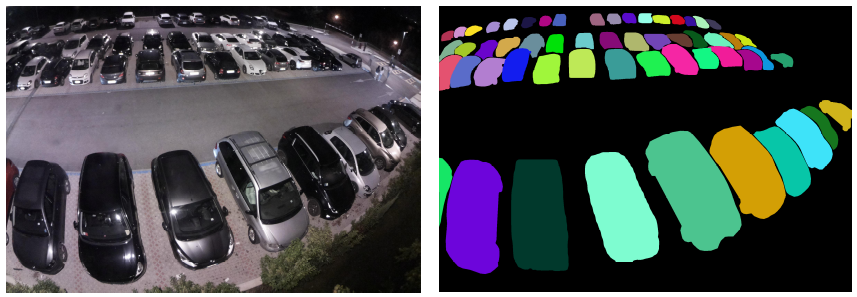

# Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cd /content/drive/MyDrive/

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

In [4]:
!pip install \
'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lhzntl5z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lhzntl5z
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=484326cb22a2f61e1f9d2b370fdb085903fc5aa1f6196bfbe66d83c415dc751e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wk8ioyqk/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [5]:
! pip install python-box

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.4 MB/s eta 0:00:00


In [6]:
! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=6f5cb92eccb1ee68972adbbd962628e424e4bcd6e1e288d999eb3e52932f08c7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c8d6f17137cd2b0b3d3724a0f1c62

In [7]:
# GPU device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Configuration

Configuration includes following things.
- hyperparameters such as num_epochs, learning_rate, and weicht_decay
- model settings such as model type, checkpoint, and freezing part
- dataset and annotaitonfile path

In [18]:
from box import Box

config = {
    "num_devices": 4,
    "batch_size": 1,
    "num_workers": 4,
    "num_epochs": 1,
    "eval_interval": 2,
    "out_dir": "/content/drive/MyDrive/Group3/sam-finetuning",
    "opt": {
        "learning_rate": 8e-4,
        "weight_decay": 1e-4, 
        "decay_factor": 10,
        "steps": [60000, 86666],
        "warmup_steps": 250,
    },
    "model": {
        "type": 'vit_b',
        "checkpoint": "sam_vit_b_01ec64.pth",
        "freeze": {
            "image_encoder": True,
            "prompt_encoder": True,
            "mask_decoder": False,
        },
    },
    "dataset": {
        "train": {
            "root_dir": "/content/drive/MyDrive/Group3/ndis_park/train/imgs",
            "annotation_file": "/content/drive/MyDrive/Group3/ndis_park/train/train_coco_annotations.json"
        },
        "val": {
            "root_dir": "/content/drive/MyDrive/Group3/ndis_park/validation/imgs",
            "annotation_file": "/content/drive/MyDrive/Group3/ndis_park/validation/val_coco_annotations.json"
        }
    }
}

cfg = Box(config)

# Dataset Load

Define class NDIS to extract image, bboxes, masks from annotation file, preprocess them, and load them on DataLoader. 

In [19]:
import os

import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [20]:
class NDIS(Dataset):

    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Filter out image_ids without any annotations
        self.image_ids = [image_id for image_id in self.image_ids if len(self.coco.getAnnIds(imgIds=image_id)) > 0]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0] # return all the dictionaries of image info with image_id
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id) # return annotation IDs with iamge IDs
        anns = self.coco.loadAnns(ann_ids) # return all the dictionaries of annotations with annotations IDs
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h]) # from bbox information, append x, y, x + w, y + h for SAM input
            mask = self.coco.annToMask(ann) # extrack mask information from ann
            masks.append(mask) 

        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes)) # apply transform to image, masks, and bboxes

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        return image, torch.tensor(bboxes), torch.tensor(masks).float()


def collate_fn(batch):
    images, bboxes, masks = zip(*batch)
    images = torch.stack(images)
    return images, bboxes, masks


class ResizeAndPad:

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size) # resize image to target_size, 1024x1024
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks] # apply transform.apply_image() to mask
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image) # apply padding to image and mask
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes


def load_datasets(cfg, img_size):
    transform = ResizeAndPad(img_size)
    train = NDIS(root_dir=cfg.dataset.train.root_dir,
                        annotation_file=cfg.dataset.train.annotation_file,
                        transform=transform)
    val = NDIS(root_dir=cfg.dataset.val.root_dir,
                      annotation_file=cfg.dataset.val.annotation_file,
                      transform=transform)

    train_dataloader = DataLoader(train,
                                  batch_size=cfg.batch_size,
                                  shuffle=True,
                                  num_workers=cfg.num_workers,
                                  collate_fn=collate_fn)
    val_dataloader = DataLoader(val,
                                batch_size=cfg.batch_size,
                                shuffle=True,
                                num_workers=cfg.num_workers,
                                collate_fn=collate_fn)
    return train_dataloader, val_dataloader

# Loss
Initialization of FocalLoss class and DiceLoss class to calculate TotalLoss.

TotalLoss = 20. * FocalLoss + DiceLoss + IoULoss

IoULoss += F.mse_loss(iou_prediction, batch_iou, reduction='sum') / num_masks

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ALPHA = 0.8
GAMMA = 2


class FocalLoss(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = torch.clamp(inputs, min=0, max=1)
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = torch.clamp(inputs, min=0, max=1)
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Model Setup, Forward

class Model for training setup and feed-foward.

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from segment_anything import sam_model_registry
from segment_anything import SamPredictor

In [23]:
class Model(nn.Module):

    def __init__(self, cfg, model):
        super().__init__()
        self.cfg = cfg
        self.model = model

    def setup(self):
        self.model.train()
        if self.cfg.model.freeze.image_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if self.cfg.model.freeze.prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if self.cfg.model.freeze.mask_decoder: # unfreeze only mask_decoder
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False

    def forward(self, images, bboxes):
        _, _, H, W = images.shape
        image_embeddings = self.model.image_encoder(images) # get image_embeddings by loading image to image_encoder
        pred_masks = []
        ious = []
        for embedding, bbox in zip(image_embeddings, bboxes):
            sparse_embeddings, dense_embeddings = self.model.prompt_encoder( # get sparse_embeddings, dense_embeddings by loading bboxes to prompt_encoder
                points=None,
                boxes=bbox,
                masks=None,
            )

            low_res_masks, iou_predictions = self.model.mask_decoder(
                image_embeddings=embedding.unsqueeze(0), 
                image_pe=self.model.prompt_encoder.get_dense_pe(), # Returns the positional encoding used to encode point prompts, applied to a dense set of points the shape of the image encoding.
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False, # ouput only one mask per objects in an image
            )

            masks = F.interpolate( # low_res_masks upsampling
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
            pred_masks.append(masks.squeeze(1))
            ious.append(iou_predictions)

        return pred_masks, ious

    def get_predictor(self):
        return SamPredictor(self.model)

# Training Function

Define train_sam for training. It includes initialization of criterian, feed-forward, loss calculation, backpropagation, and weight upgrading.

In [24]:
import statistics

def train_sam(cfg, model, optimizer, scheduler, train_dataloader, val_dataloader):

    train_loss = []

    focal_loss = FocalLoss()
    dice_loss = DiceLoss()
    
    for epoch in range(cfg.num_epochs):
      
      for iter, data in enumerate(train_dataloader):
          images, bboxes, gt_masks = data

          # load batch on GPU device
          images = images.to(device)
          bboxes = torch.stack(bboxes, dim=0)
          bboxes = bboxes.cuda()
          bboxes = list(bboxes)
          gt_masks = torch.stack(gt_masks, dim=0)
          gt_masks = gt_masks.cuda()
          gt_masks = list(gt_masks)

          batch_size = images.size(0)
          pred_masks, iou_predictions = model(images, bboxes) # feed-forward
          num_masks = sum(len(pred_mask) for pred_mask in pred_masks)
          loss_focal = torch.tensor(0., device=device)
          loss_dice = torch.tensor(0., device=device)
          loss_iou = torch.tensor(0., device=device)

          for pred_mask, gt_mask, iou_prediction in zip(pred_masks, gt_masks, iou_predictions): 
            
            # compute batch_iou of pred_mask and gt_mask
            pred_mask = (pred_mask >= 0.5).float() 
            intersection = torch.sum(torch.mul(pred_mask, gt_mask), dim=(1,2))
            union = torch.sum(pred_mask, dim=(1,2))
            epsilon = 1e-7
            batch_iou = (intersection / (union + epsilon)).unsqueeze(1)

            loss_focal += focal_loss(pred_mask, gt_mask, num_masks)
            loss_dice += dice_loss(pred_mask, gt_mask, num_masks)
            loss_iou += F.mse_loss(iou_prediction, batch_iou, reduction='sum') / num_masks

          loss_total = 20. * loss_focal + loss_dice + loss_iou
          optimizer.zero_grad()
          loss_total.backward()
          optimizer.step()
          scheduler.step()

          avg_focal = loss_focal.item() / batch_size # compute average loss of a batch
          avg_dice = loss_dice.item() / batch_size
          avg_iou = loss_iou.item() / batch_size
          avg_total = loss_total.item() / batch_size

          train_loss.append(loss_total.item())

          print(f'-- Epoch: [{epoch+1}] Iteration: {iter+1}/{len(train_dataloader)//batch_size} --')
          print(f'Focal Loss [{loss_focal.item():.4f}] [avg: {avg_focal:.4f}]')
          print(f'Dice Loss [{loss_dice.item():.4f}] [avg: {avg_dice:.4f}]')
          print(f'IoU Loss [{loss_iou.item():.4f}] [avg: {avg_iou:.4f}]')
          print(f'Total Loss [{loss_total.item():.4f}] [avg: {avg_total:.4f}] \n')


    print(f'-- Epoch: [{epoch+1}] Mean Total Loss: [{statistics.mean(train_loss):.4f}] --\n')

# Validation Function
Define funtion for validation

In [25]:
import segmentation_models_pytorch as smp
import statistics

def validate(model, val_dataloader, epoch=0):
  model.eval() # turn the model into evaluation mode

  val_loss_list = []

  focal_loss = FocalLoss()
  dice_loss = DiceLoss()

  with torch.no_grad(): # turn off requires_grad
    for iter, data in enumerate(val_dataloader):

      images, bboxes, gt_masks = data

      # load batch on GPU device
      images = images.to(device)
      bboxes = torch.stack(bboxes, dim=0)
      bboxes = bboxes.cuda()
      bboxes = list(bboxes)
      gt_masks = torch.stack(gt_masks, dim=0)
      gt_masks = gt_masks.cuda()
      gt_masks = list(gt_masks)

      batch_size = images.size(0)
      pred_masks, iou_predictions = model(images, bboxes)
      num_masks = sum(len(pred_mask) for pred_mask in pred_masks)
      loss_focal = torch.tensor(0., device=device)
      loss_dice = torch.tensor(0., device=device)
      loss_iou = torch.tensor(0., device=device)

      for pred_mask, gt_mask, iou_prediction in zip(pred_masks, gt_masks, iou_predictions): 

        # compute batch_iou of pred_mask and gt_mask
        pred_mask = (pred_mask >= 0.5).float() 
        intersection = torch.sum(torch.mul(pred_mask, gt_mask), dim=(1,2))
        union = torch.sum(pred_mask, dim=(1,2))
        epsilon = 1e-7
        batch_iou = (intersection / (union + epsilon)).unsqueeze(1)

        loss_focal += focal_loss(pred_mask, gt_mask, num_masks)
        loss_dice += dice_loss(pred_mask, gt_mask, num_masks)
        loss_iou += F.mse_loss(iou_prediction, batch_iou, reduction='sum') / num_masks

      loss_total = 20. * loss_focal + loss_dice + loss_iou
      val_loss_list.append(loss_total.item())

      avg_focal = loss_focal.item() / batch_size # compute average loss of a batch
      avg_dice = loss_dice.item() / batch_size
      avg_iou = loss_iou.item() / batch_size
      avg_total = loss_total.item() / batch_size

      print(f'-- Epoch: [{epoch}] Iteration: {iter+1}/{len(val_dataloader)//batch_size} --')
      print(f'Focal Loss [{loss_focal.item():.4f}] [avg: {avg_focal:.4f}]')
      print(f'Dice Loss [{loss_dice.item():.4f}] [avg: {avg_dice:.4f}]')
      print(f'IoU Loss [{loss_iou.item():8f}] [avg: {avg_iou:.8f}]')
      print(f'Total Loss [{loss_total.item():.4f}] [avg: {avg_total:.4f}] \n')
  
    total_loss_mean = statistics.mean(val_loss_list)
    print(f'Validation [{epoch}]: Total Loss: [{total_loss_mean:.4f}]')

    print(f"\nSaving checkpoint to {cfg.out_dir}")
    state_dict = model.model.state_dict()
    torch.save(state_dict, os.path.join(cfg.out_dir, f"epoch-{epoch}-valloss-{total_loss_mean:.2f}-ckpt.pth"))

Define function for learning rate schedular

In [26]:
def lr_lambda(step):
        if step < cfg.opt.warmup_steps:
            return step / cfg.opt.warmup_steps
        elif step < cfg.opt.steps[0]:
            return 1.0
        elif step < cfg.opt.steps[1]:
            return 1 / cfg.opt.decay_factor
        else:
            return 1 / (cfg.opt.decay_factor**2)

# Let's Train!

Initialize model instance, load train_data and val_data, optimizer, and learning rate scheduler

In [27]:
# load SAM checkpoint 
sam = sam_model_registry[cfg.model.type](checkpoint=cfg.model.checkpoint)

model = Model(cfg, sam).to(device)
model.setup()

train_data, val_data = load_datasets(cfg, model.model.image_encoder.img_size)

optimizer = torch.optim.Adam(model.model.parameters(), lr=cfg.opt.learning_rate, weight_decay=cfg.opt.weight_decay)

# In the paper, the authors used AdamW for training.
# optimizer = torch.optim.AdamW(model.model.parameters(), lr=cfg.opt.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=cfg.opt.weight_decay, amsgrad=False)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

train_sam(cfg, model, optimizer, scheduler, train_data, val_data)

loading annotations into memory...
Done (t=2.55s)
creating index...
index created!
loading annotations into memory...
Done (t=1.63s)
creating index...
index created!
-- Epoch: [1] Iteration: 1/111 --
Focal Loss [1.2107] [avg: 1.2107]
Dice Loss [0.9949] [avg: 0.9949]
IoU Loss [0.0032] [avg: 0.0032]
Total Loss [25.2130] [avg: 25.2130] 

-- Epoch: [1] Iteration: 2/111 --
Focal Loss [0.5194] [avg: 0.5194]
Dice Loss [0.9970] [avg: 0.9970]
IoU Loss [0.0149] [avg: 0.0149]
Total Loss [11.3991] [avg: 11.3991] 

-- Epoch: [1] Iteration: 3/111 --
Focal Loss [12.4267] [avg: 12.4267]
Dice Loss [0.9888] [avg: 0.9888]
IoU Loss [0.0097] [avg: 0.0097]
Total Loss [249.5329] [avg: 249.5329] 

-- Epoch: [1] Iteration: 4/111 --
Focal Loss [2.5840] [avg: 2.5840]
Dice Loss [0.9831] [avg: 0.9831]
IoU Loss [0.0062] [avg: 0.0062]
Total Loss [52.6697] [avg: 52.6697] 

-- Epoch: [1] Iteration: 5/111 --
Focal Loss [0.8653] [avg: 0.8653]
Dice Loss [0.9964] [avg: 0.9964]
IoU Loss [0.0017] [avg: 0.0017]
Total Loss [1

In [28]:
state_dict = model.model.state_dict()
torch.save(state_dict, os.path.join(cfg.out_dir, f"epoch-{1}-loss-{81.41}-ckpt.pth"))

# **Validation**

In [29]:
_, val_data = load_datasets(cfg, model.model.image_encoder.img_size)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [30]:
validate(model, val_data, epoch=1)

-- Epoch: [1] Iteration: 1/30 --
Focal Loss [1.0368] [avg: 1.0368]
Dice Loss [0.9860] [avg: 0.9860]
IoU Loss [0.002908] [avg: 0.00290756]
Total Loss [21.7253] [avg: 21.7253] 

-- Epoch: [1] Iteration: 2/30 --
Focal Loss [1.9019] [avg: 1.9019]
Dice Loss [0.9859] [avg: 0.9859]
IoU Loss [0.019357] [avg: 0.01935699]
Total Loss [39.0436] [avg: 39.0436] 

-- Epoch: [1] Iteration: 3/30 --
Focal Loss [4.6728] [avg: 4.6728]
Dice Loss [0.9934] [avg: 0.9934]
IoU Loss [0.017116] [avg: 0.01711602]
Total Loss [94.4671] [avg: 94.4671] 

-- Epoch: [1] Iteration: 4/30 --
Focal Loss [11.9519] [avg: 11.9519]
Dice Loss [0.9900] [avg: 0.9900]
IoU Loss [0.042183] [avg: 0.04218320]
Total Loss [240.0692] [avg: 240.0692] 

-- Epoch: [1] Iteration: 5/30 --
Focal Loss [2.0773] [avg: 2.0773]
Dice Loss [0.9964] [avg: 0.9964]
IoU Loss [0.013443] [avg: 0.01344335]
Total Loss [42.5550] [avg: 42.5550] 

-- Epoch: [1] Iteration: 6/30 --
Focal Loss [0.6923] [avg: 0.6923]
Dice Loss [0.9911] [avg: 0.9911]
IoU Loss [0.1170

# **Inference after Fine-Tuning**

Instance segmentation experiment with fine-tuned model

Set-up

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
# Load up the the finetuned model
from segment_anything import sam_model_registry, SamPredictor

sam_finetuned = sam_model_registry['vit_b'](checkpoint='/content/drive/MyDrive/Group3/sam-finetuning/epoch-2-loss-81.46-ckpt.pth')
sam_finetuned.to(device);

Get an image for inference

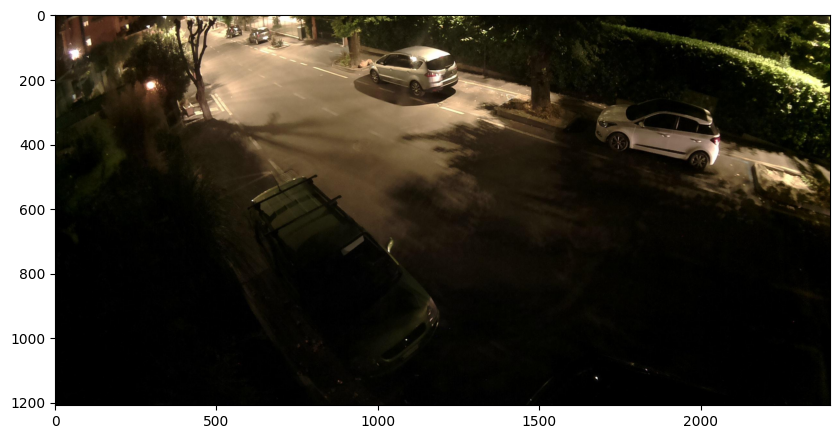

In [34]:
image1 = cv2.imread('/content/drive/MyDrive/Group3/ndis_park/validation/imgs/83_1537047041.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image1)
plt.axis('on')
plt.show()

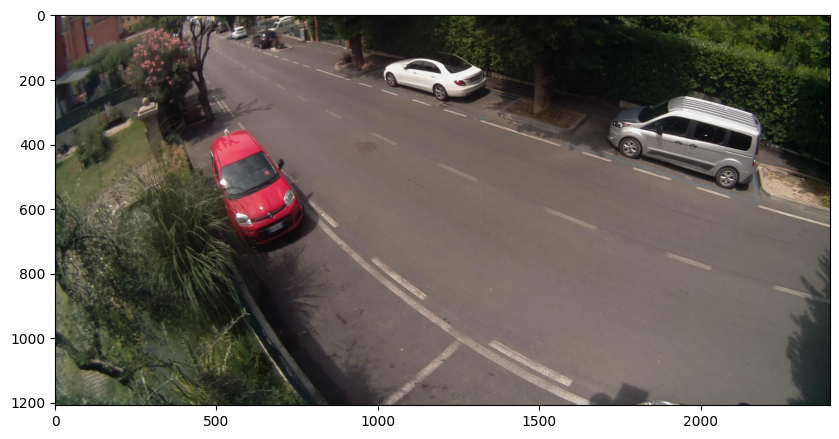

In [35]:
image2 = cv2.imread('/content/drive/MyDrive/Group3/ndis_park/validation/imgs/83_1531740623.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image2)
plt.axis('on')
plt.show()

In [36]:
# Set up predictors for tuned model
predictor1 = SamPredictor(sam_finetuned)
predictor2 = SamPredictor(sam_finetuned)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [37]:
predictor1.set_image(image1)
predictor2.set_image(image2)

In [38]:
# multiple input prompts
input_boxes1 = torch.tensor([
    [970.0, 108.0, 1237.0, 240.0],
    [1686.0, 272.0, 2050.0, 463.0],
    [534.0, 37.0, 578.0, 71.0],
    [603.0, 40.0, 670.0, 92.0 ],
    [599.0, 507.0, 1187.0, 1117.0],
    [1465.0, 1059.0, 2149.0, 1205.0]
], device=predictor1.device)

In [39]:
input_boxes2 = torch.tensor([
    [484.0, 359.0, 765.0, 708.0],
    [660.0, 7.0, 743.0, 59.0],
    [613.0, 51.0, 687.0, 105.0 ],
    [544.0, 38.0, 594.0, 76.0],
    [498.0, 30.0, 537.0, 59.0],
    [1022.0, 132.0, 1324.0, 251.0],
    [1737.0, 265.0, 2164.0, 524.0]
], device=predictor2.device)

Functions for showing masks and bboxes

In [40]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access.

In [41]:
transformed_boxes = predictor1.transform.apply_boxes_torch(input_boxes1, image1.shape[:2])
masks, _, _ = predictor1.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

Visualise mask predictions. Because epoch for fine-tuning was only 2, we can see that the model dimly creates relatively bigger masks while smaller masks were created distinctly.

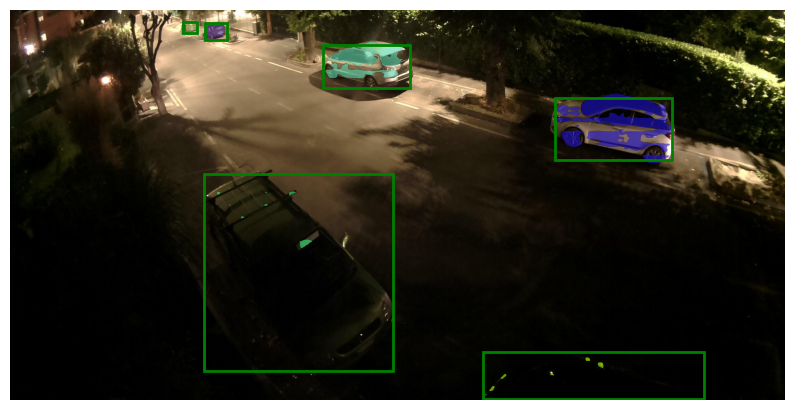

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(image1)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes1:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [43]:
transformed_boxes = predictor2.transform.apply_boxes_torch(input_boxes2, image1.shape[:2])
masks, _, _ = predictor2.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

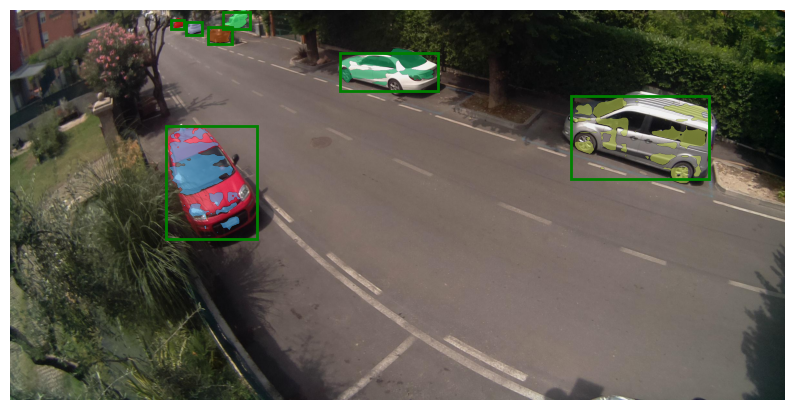

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(image2)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes2:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()